In this assignment, we'll be looking at the Housing Prices dataset from Kaggle. In short, we'll be predicting housing prices. In detail, here's what I'll be doing:

- Load the dataset from the csv files.
- Investigate the data, and do any necessary data cleaning.
- Explore the data and find some variables that I think would be useful in predicting house prices.
- Build an initial model using these features and estimate the parameters using OLS.


In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

houses = pd.read_csv('train.csv')

In [14]:
houses.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd
0,208500,7,1710,2,548,856,2,2003,2003
1,181500,6,1262,2,460,1262,2,1976,1976
2,223500,7,1786,2,608,920,2,2001,2002
3,140000,7,1717,3,642,756,1,1915,1970
4,250000,8,2198,3,836,1145,2,2000,2000


Data is loaded. We already know the target variable is the sales price. Let's take a look at its distribution:

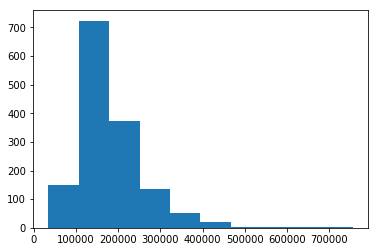

In [3]:
plt.hist(houses.SalePrice)
plt.show()

In [4]:
houses.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageCond         81
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageQual         81
BsmtExposure       38
BsmtFinType2       38
BsmtFinType1       37
BsmtCond           37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
Utilities           0
YearRemodAdd        0
MSSubClass          0
Foundation          0
ExterCond           0
ExterQual           0
Exterior2nd         0
Exterior1st         0
RoofMatl            0
RoofStyle           0
YearBuilt           0
                 ... 
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
3SsnPorch           0
BsmtUnfSF           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
Functional          0
TotRmsAbvGrd        0
KitchenQua

We have 19 features with missing values, most of which are housing extras that may not significantly correlate with SalePrice. Let's draw a correlation table to be sure. But first, let's move the target variable column to the front:

In [5]:
# get a list of columns
cols = list(houses)

# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('SalePrice')))
cols.remove('Id')
# use ix to reorder
houses = houses.ix[:, cols]
houses.head()

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,208500,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,181500,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,223500,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,140000,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,250000,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [6]:
houses.corr().sort_values(by='SalePrice',ascending=False)

,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
SalePrice,1.000000,-0.084284,0.351799,0.263843,0.790982,-0.077856,0.522897,0.507101,0.477493,0.386420,...,0.623431,0.324413,0.315856,-0.128578,0.044584,0.111447,0.092404,-0.021190,0.046432,-0.028923
OverallQual,0.790982,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347
GrLivArea,0.708624,0.074853,0.402797,0.263116,0.593007,-0.079686,0.199010,0.287389,0.390857,0.208171,...,0.468997,0.247433,0.330224,0.009113,0.020643,0.101510,0.170205,-0.002416,0.050240,-0.036526
GarageCars,0.640409,-0.040110,0.285691,0.154871,0.600671,-0.185758,0.537850,0.420622,0.364204,0.224054,...,0.882475,0.226342,0.213569,-0.151434,0.035765,0.050494,0.020934,-0.043080,0.040522,-0.039117
GarageArea,0.623431,-0.098672,0.344997,0.180403,0.562022,-0.151521,0.478954,0.371600,0.373066,0.296970,...,1.000000,0.224666,0.241435,-0.121777,0.035087,0.051412,0.061047,-0.027400,0.027974,-0.027378
TotalBsmtSF,0.613581,-0.238518,0.392075,0.260833,0.537808,-0.171098,0.391452,0.291066,0.363936,0.522396,...,0.486665,0.232019,0.247264,-0.095478,0.037384,0.084489,0.126053,-0.018479,0.013196,-0.014969
1stFlrSF,0.605852,-0.251758,0.457181,0.299475,0.476224,-0.144203,0.281986,0.240379,0.344501,0.445863,...,0.489782,0.235459,0.211671,-0.065292,0.056104,0.088758,0.131525,-0.021096,0.031372,-0.013604
FullBath,0.560664,0.131608,0.198769,0.126031,0.550600,-0.194149,0.468271,0.439046,0.276833,0.058543,...,0.405656,0.187703,0.259977,-0.115093,0.035353,-0.008106,0.049604,-0.014290,0.055872,-0.019669
TotRmsAbvGrd,0.533723,0.040380,0.352096,0.190015,0.427452,-0.057583,0.095589,0.191740,0.280682,0.044316,...,0.337822,0.165984,0.234192,0.004151,-0.006683,0.059383,0.083757,0.024763,0.036907,-0.034516
YearBuilt,0.522897,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618


We are initially interested in the first 11 features (the ones with more than 50% correlation with SalePrice). However, since houses tend to have many features that correlate with each other, let's draw a heatmap and pick out the features that are correlated with each other:

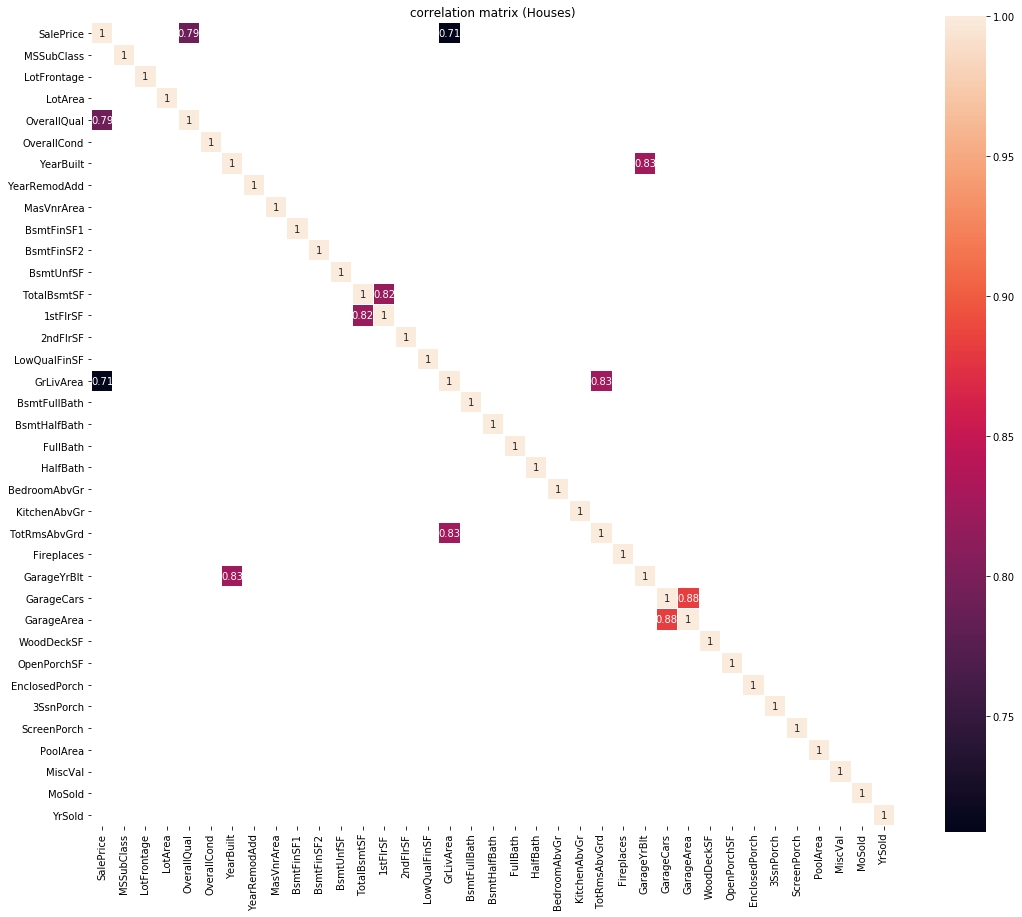

In [7]:
# make the correlation matrix.
corr_mat_houses = houses.corr()
corr_mat_houses = corr_mat_houses[corr_mat_houses > .7]


plt.figure(figsize=(18,15))

plt.plot(1,1)
# draw the heatmap using seaborn.
sns.heatmap(corr_mat_houses, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Houses)")

plt.show()

# try to match the correlation numbers 
# to the scatterplots above to get a 
# sense of what each magnitude of 
# correlation can look like.


We can notice that YearBuilt strongly correlates with GarageYrBlt, due to usually building houses with garages included. Also, TotRmsAbvGrd (total rooms above ground) correlates with GrLivArea, and the YrSold correlates with two other features, but the latter won't matter since it doesn't significantly correlate with SalePrice.

Therefore, the dataset we'll pick will consist of the 11 correlating features minus the ones that correlate with other features:

In [8]:
houses = houses[['SalePrice','OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','FullBath','YearBuilt','YearRemodAdd']]

How do these features look against the target?

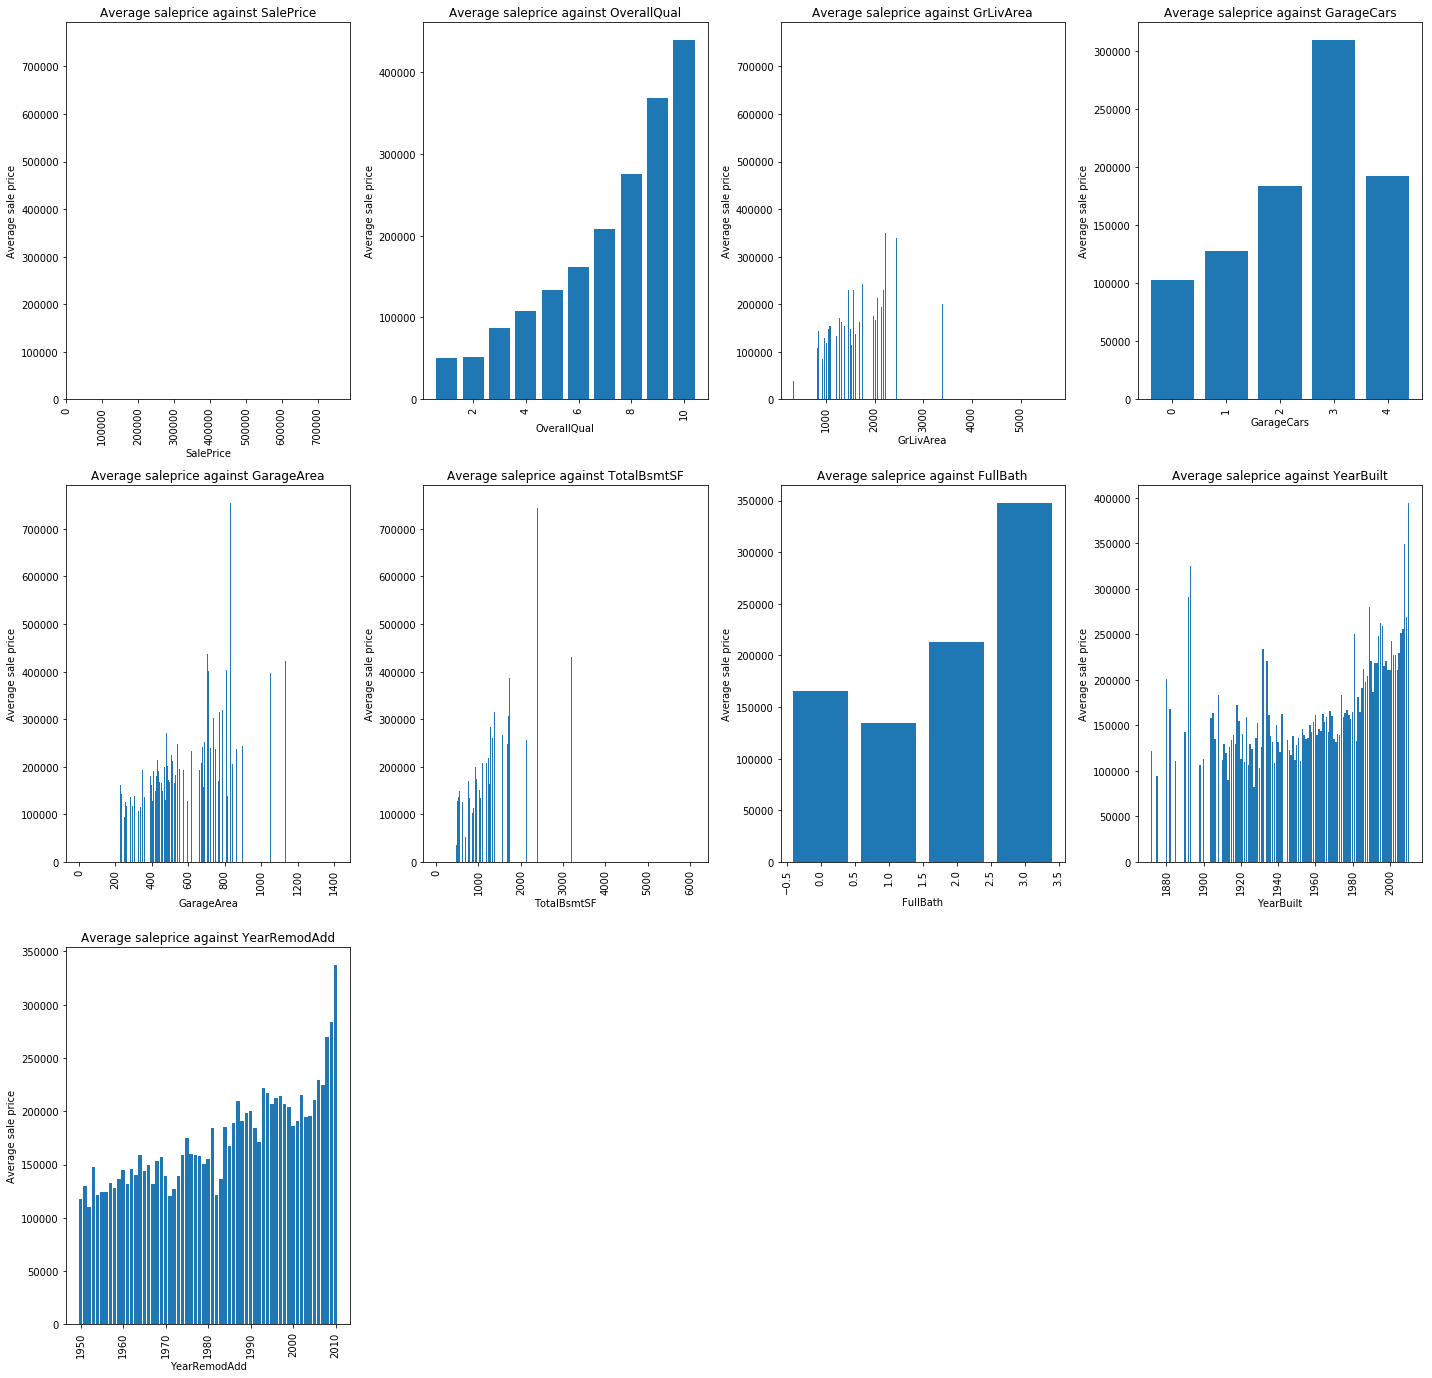

In [9]:
plt.figure(figsize=(20,70))

for index, column in enumerate(houses.columns):
    plt.subplot(11,4,index+1)
    plt.bar(houses.groupby(column)["SalePrice"].mean().index, houses.groupby(column)["SalePrice"].mean())
    plt.title("Average saleprice against {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

We can see clear trends as each of these variables increase in value, this is due to a significant positive correlation with the target variable.

Now we move to check the type of data in each of these variables:

In [10]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
SalePrice       1460 non-null int64
OverallQual     1460 non-null int64
GrLivArea       1460 non-null int64
GarageCars      1460 non-null int64
GarageArea      1460 non-null int64
TotalBsmtSF     1460 non-null int64
FullBath        1460 non-null int64
YearBuilt       1460 non-null int64
YearRemodAdd    1460 non-null int64
dtypes: int64(9)
memory usage: 102.7 KB


All of these variables are integers. Therefore no onehot encoding needed. Let's proceed to create our regression model:

In [13]:
features = list(houses.columns)
features.remove('SalePrice')

X = houses[features]
Y = houses['SalePrice']


X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     615.5
Date:                Tue, 27 Aug 2019   Prob (F-statistic):               0.00
Time:                        22:11:31   Log-Likelihood:                -17463.
No. Observations:                1460   AIC:                         3.494e+04
Df Residuals:                    1451   BIC:                         3.499e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.158e+06   1.28e+05     -9.030      0.000   -1.41e+06   -9.07e+05
OverallQual   1.923e+04   1183.567     16.248      0.000    1.69e+04    2.16e+04
GrLivArea       53.8303      2.996     17.968      0.000      47.953      59.707
GarageCars    1.054e+04   3039.969      3.467      0.001    4576.313    1.65e+04
GarageArea      16.8986     10.286      1.643      0.101      -3.278      37.075
TotalBsmtSF     28.9796      2.885     10.044      0.000      23.320      34.639
FullBath     -6394.9604   2660.790     -2.403      0.016   -1.16e+04   -1175.555
YearBuilt      257.9006     50.164      5.141      0.000     159.499     356.302
YearRemodAdd   294.6293     63.752      4.621      0.000     169.573     419.685
==============================================================================
Omnibus:                      485.531   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            60951.563
Skew:                          -0.441   Prob(JB):                         0.00
Kurtosis:                      34.641   Cond. No.                     4.39e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""